<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`is_fraudulent`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [65]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer, StandardScaler

from scipy.stats import chi2_contingency

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Librería para el acceso a variables y funciones
# -----------------------------------------------------------------------
import sys
sys.path.append("../")
from src import soporte_preprocesamiento as sp
from src import soporte_nulos as sn
from src import soporte_encoding as se
from src import soporte_scaling as ss

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# EDA

In [66]:
df = pd.read_csv("datos/financial_data.csv")
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [67]:
sp.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 11

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,5000.500000,2886.895680,1.00,2500.750,5000.500,7500.2500,10000.00
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 00:00:00,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


None

- Vemos que, no tenemos valores nulos ni duplicados. Continuamos analizando las variables que tenemos con un análisis visual:

In [68]:
df_num, df_cat = sp.separar_dataframe(df)

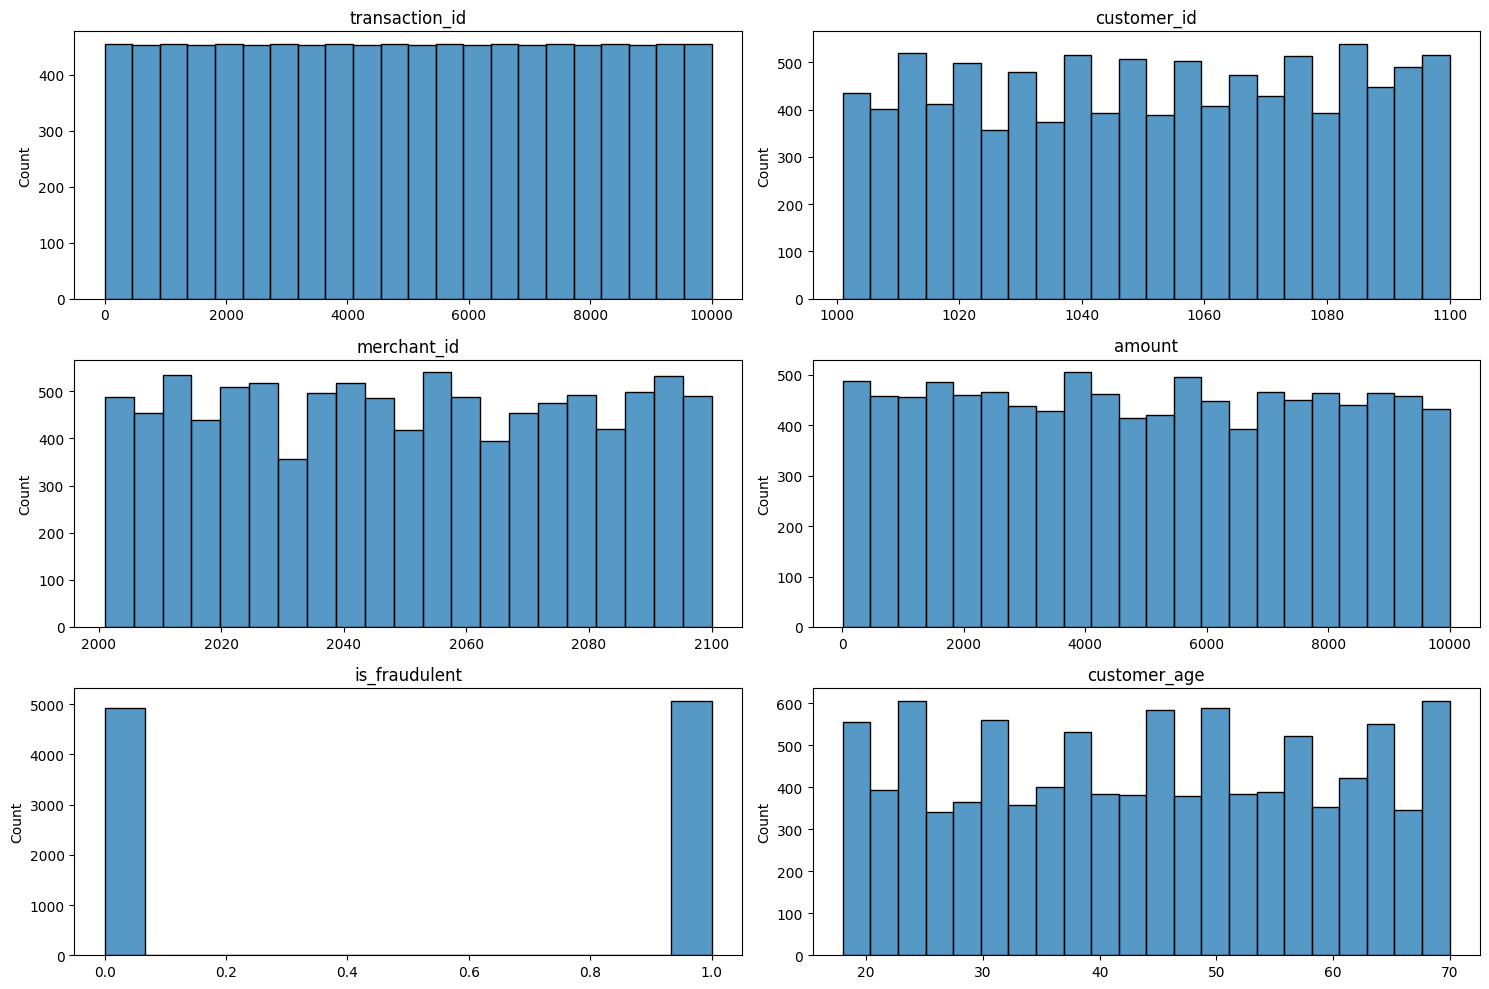

In [69]:
sp.plot_numericas(df_num)

- De esta gráfica podemos scar varias conclusiones:
    - Los ID merchant_id y customer_id corresponden a identificadores del vendedor y el cliente, por lo que, no corresponden a variables numéricas, sino categóricas (son una etiqueta). Las mantenemos porque podría haber relaciones entre fraude y cada uno de ellas.
    - Por su parte, el transaction_id, al ser un identificador único de la transacción, podemos eliminarlo.
    - La variable is_fraudulent, es de tipo "category", por no ser continua (son 0 y 1), le cambiaremos el tipo a categórica.
    - Como variables numéricas tenemos la edad y la cantidad.

- Por otro lado, hemos identificado que, la columna *transaction_description* contiene la misma información que *merchant_id*, con lo cual, la eliminaremos. Lo mismo haremos con *transaction_time*, dado que contiene datos erróneos secuenciales de 1 segundo para una misma fecha.

In [70]:
df.drop(columns=["transaction_id", "transaction_description", "transaction_time"], inplace=True)

In [71]:
df[["customer_id", "merchant_id"]] = df[["customer_id", "merchant_id"]].astype(str)

In [72]:
df.describe()

,amount,is_fraudulent,customer_age
count,10000.000000,10000.000000,10000.000000
mean,4958.381617,0.506800,44.047500
std,2899.699675,0.499979,15.321707
min,10.610000,0.000000,18.000000
25%,2438.175000,0.000000,31.000000
50%,4943.945000,1.000000,44.000000
75%,7499.312500,1.000000,57.000000
max,9999.750000,1.000000,70.000000


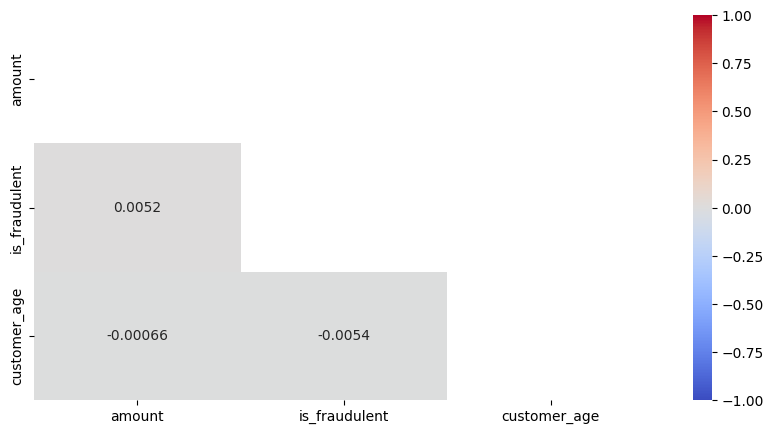

In [73]:
sp.matriz_correlacion(df)

- Vemos que, las correlaciones son muy débiles.

- Separamos de nuevo las columnas según los cambios que hemos realizado.

In [74]:
df_num, df_cat = sp.separar_dataframe(df)

In [75]:
df.dtypes

customer_id           object
merchant_id           object
amount               float64
is_fraudulent          int64
card_type             object
location              object
purchase_category     object
customer_age           int64
dtype: object

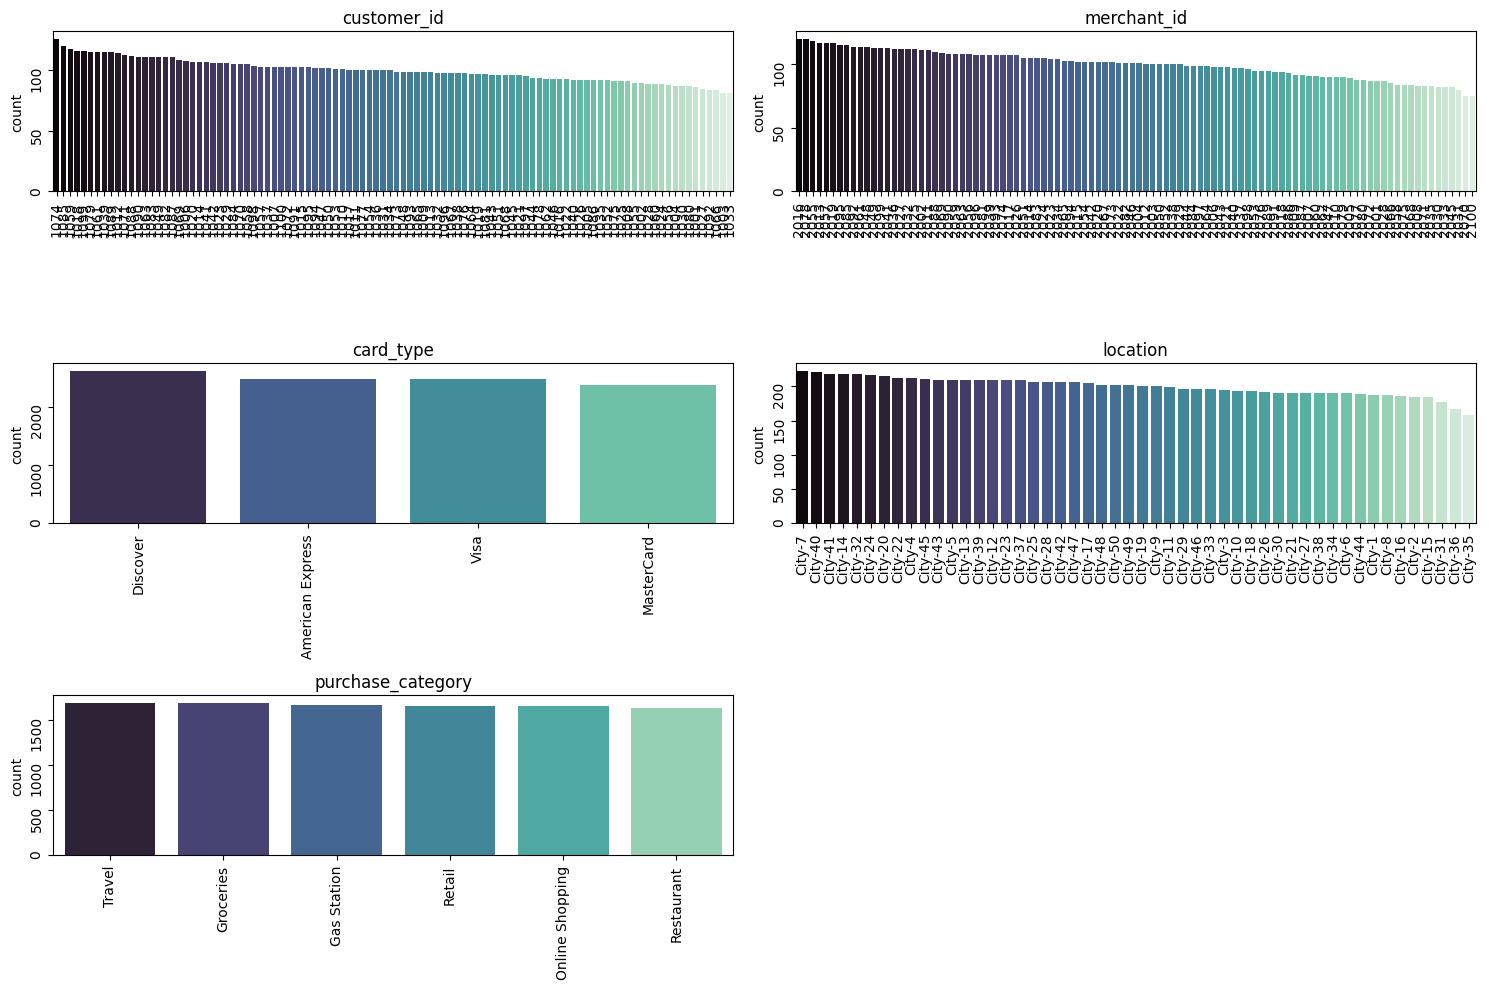

In [76]:
sp.plot_cat(df_cat)

- A simple vista, no hay desbalanceo. En purchase_category parecen estar bastante equilibradas, en card_type tendremos que hacer una comprobación.

## Encoding

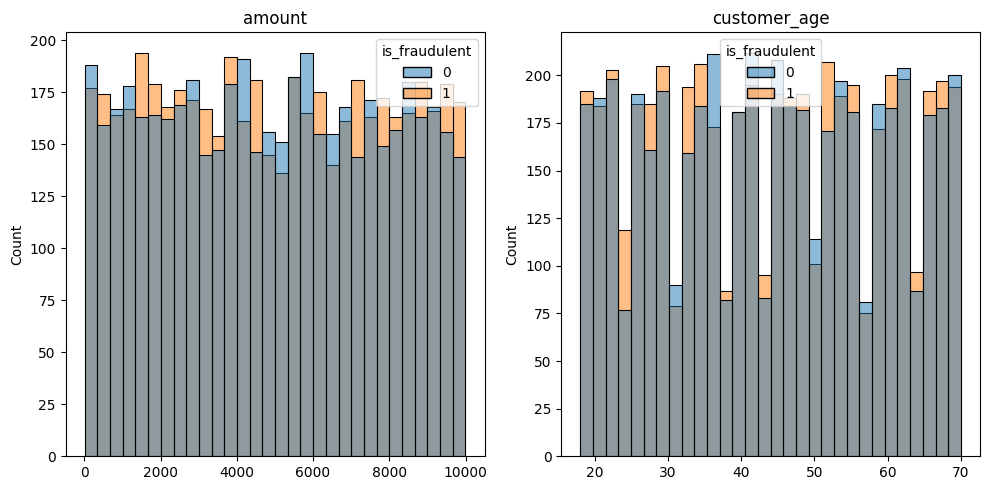

In [77]:
df["is_fraudulent"] = df["is_fraudulent"].astype(str)
sp.relacion_vr_numericas_prob_cat(df, "is_fraudulent", figsize=(10,5))

In [78]:
df["is_fraudulent"] = df["is_fraudulent"].astype(int)
sp.detectar_orden_cat(df, lista_cat=df.select_dtypes(include = ["object", "category"]), var_respuesta="is_fraudulent")

Estamos evalando la variable CUSTOMER_ID


is_fraudulent,0,1
customer_id,,
1001,44,42
1002,45,45
1003,37,44
1004,36,51
1005,47,45
...,...,...
1096,46,52
1097,45,50
1098,46,58


La variable customer_id NO tiene orden. ❌
_________________________ 

Estamos evalando la variable MERCHANT_ID


is_fraudulent,0,1
merchant_id,,
2001,45,42
2002,59,52
2003,46,54
2004,49,52
2005,38,51
...,...,...
2096,59,48
2097,53,46
2098,44,52


La variable merchant_id NO tiene orden. ❌
_________________________ 

Estamos evalando la variable CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


La variable card_type NO tiene orden. ❌
_________________________ 

Estamos evalando la variable LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


La variable location NO tiene orden. ❌
_________________________ 

Estamos evalando la variable PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


La variable purchase_category si tiene orden. ✅
_________________________ 



In [79]:
diccionario_encoding = {
    "onehot": ["card_type"],
    "dummies": [],
    "ordinal": {},
    "label": [],
    "frequency": [],
    "target": ['customer_id', 'merchant_id',
       'location', 'purchase_category']
}

In [80]:
encoding = se.Encoding(df, diccionario_encoding, "is_fraudulent")

In [81]:
oh_enc, oh_encoder = encoding.one_hot_encoding()
oh_enc.head()

,customer_id,merchant_id,amount,is_fraudulent,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
0,1082,2027,5758.59,0,City-30,Gas Station,43,0.0,0.0,1.0,0.0
1,1015,2053,1901.56,1,City-47,Online Shopping,61,0.0,0.0,0.0,1.0
2,1004,2035,1248.86,1,City-6,Gas Station,57,0.0,0.0,1.0,0.0
3,1095,2037,7619.05,1,City-6,Travel,59,0.0,1.0,0.0,0.0
4,1036,2083,1890.10,1,City-34,Retail,36,0.0,0.0,1.0,0.0


In [82]:
ta_enc, target_encoder = encoding.target_encoding()
ta_enc.head()

,customer_id,merchant_id,amount,is_fraudulent,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
0,0.540541,0.517857,5758.59,0,0.497382,0.524610,43,0.0,0.0,1.0,0.0
1,0.543689,0.536842,1901.56,1,0.529126,0.486978,61,0.0,0.0,0.0,1.0
2,0.586207,0.506024,1248.86,1,0.600000,0.524610,57,0.0,0.0,1.0,0.0
3,0.543689,0.525773,7619.05,1,0.600000,0.505313,59,0.0,1.0,0.0,0.0
4,0.470000,0.523810,1890.10,1,0.497382,0.513546,36,0.0,0.0,1.0,0.0


## Gestión de Outliers

In [83]:
col_numericas = ['amount', 'customer_age']
col_numericas

['amount', 'customer_age']

In [84]:
#df["is_fraudulent"] = df["is_fraudulent"].astype(int)
sn.visualizar_outliers(ta_enc, col_numericas)

In [85]:
contaminacion = [0.01, 0.05] # número de árboles
estimadores = [25, 50, 75]

df_outliers = sn.outliers_isolation_forest(ta_enc, contaminacion, estimadores)
df_outliers.head()

,customer_id,merchant_id,amount,is_fraudulent,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,outliers_ifo_0.01_25,outliers_ifo_0.01_50,outliers_ifo_0.01_75,outliers_ifo_0.05_25,outliers_ifo_0.05_50,outliers_ifo_0.05_75
0,0.540541,0.517857,5758.59,0,0.497382,0.524610,43,0.0,0.0,1.0,0.0,1,1,1,1,1,1
1,0.543689,0.536842,1901.56,1,0.529126,0.486978,61,0.0,0.0,0.0,1.0,1,1,1,1,1,1
2,0.586207,0.506024,1248.86,1,0.600000,0.524610,57,0.0,0.0,1.0,0.0,1,1,1,-1,-1,1
3,0.543689,0.525773,7619.05,1,0.600000,0.505313,59,0.0,1.0,0.0,0.0,1,1,1,1,1,1
4,0.470000,0.523810,1890.10,1,0.497382,0.513546,36,0.0,0.0,1.0,0.0,1,1,1,1,1,1


- Filtraremos las filas con más de un 70% de outliers.

In [86]:
cantidad_col = 3
df_filtrado = df_outliers[(ta_enc == -1).sum(axis=1) > cantidad_col]
df_filtrado.head()

,customer_id,merchant_id,amount,is_fraudulent,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,outliers_ifo_0.01_25,outliers_ifo_0.01_50,outliers_ifo_0.01_75,outliers_ifo_0.05_25,outliers_ifo_0.05_50,outliers_ifo_0.05_75
93,0.585106,0.642202,1069.05,1,0.475676,0.479829,63,1.0,0.0,0.0,0.0,1,1,-1,-1,-1,-1
421,0.504854,0.630952,4680.17,0,0.600000,0.486978,64,1.0,0.0,0.0,0.0,1,1,-1,-1,-1,-1
424,0.556522,0.504762,8144.13,0,0.600000,0.529551,67,0.0,0.0,1.0,0.0,1,-1,-1,1,-1,-1
556,0.529412,0.637255,5654.85,1,0.569307,0.479829,19,0.0,1.0,0.0,0.0,-1,1,-1,-1,-1,-1
597,0.592920,0.500000,8977.92,0,0.600000,0.479829,61,0.0,0.0,1.0,0.0,-1,-1,-1,-1,-1,-1


In [87]:
df_filtrado.shape

(116, 17)

- Dado que los detectados se corresponden con un 1% de los datos, eliminaremos estas filas.

In [88]:
ta_enc = ta_enc.drop(index=df_filtrado.index)
ta_enc.reset_index(drop=True, inplace=True)

In [89]:
ta_enc.shape

(9884, 17)

In [90]:
ta_enc.columns

Index(['customer_id', 'merchant_id', 'amount', 'is_fraudulent', 'location',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa',
       'outliers_ifo_0.01_25', 'outliers_ifo_0.01_50', 'outliers_ifo_0.01_75',
       'outliers_ifo_0.05_25', 'outliers_ifo_0.05_50', 'outliers_ifo_0.05_75'],
      dtype='object')

In [91]:
ta_enc.drop(columns= ['outliers_ifo_0.01_25',
       'outliers_ifo_0.01_50', 'outliers_ifo_0.01_75', 'outliers_ifo_0.05_25',
       'outliers_ifo_0.05_50', 'outliers_ifo_0.05_75'], inplace=True)

## Feature Scaling

- Usaremos el MinMaxScaler() para mantener la integridad de los datos resultantes del OneHotEncoder.

In [92]:
df_escaladores_graf = ss.aplicar_escaladores(ta_enc, ["amount", "customer_age"], [RobustScaler(), MinMaxScaler(), StandardScaler(), Normalizer()])
df_escaladores_graf

,customer_id,merchant_id,amount,is_fraudulent,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,amount_robust,customer_age_robust,amount_minmax,customer_age_minmax,amount_standard,customer_age_standard,amount_normalizer,customer_age_normalizer
0,0.540541,0.517857,5758.59,0,0.497382,0.524610,43,0.0,0.0,1.0,0.0,0.163056,-0.038462,0.575423,0.480769,0.277768,-0.066341,0.999972,0.007467
1,0.543689,0.536842,1901.56,1,0.529126,0.486978,61,0.0,0.0,0.0,1.0,-0.603334,0.653846,0.189301,0.826923,-1.057804,1.113237,0.999486,0.032062
2,0.586207,0.506024,1248.86,1,0.600000,0.524610,57,0.0,0.0,1.0,0.0,-0.733026,0.500000,0.123960,0.750000,-1.283814,0.851109,0.998960,0.045594
3,0.543689,0.525773,7619.05,1,0.600000,0.505313,59,0.0,1.0,0.0,0.0,0.532729,0.576923,0.761671,0.788462,0.921989,0.982173,0.999970,0.007744
4,0.470000,0.523810,1890.10,1,0.497382,0.513546,36,0.0,0.0,1.0,0.0,-0.605612,-0.307692,0.188153,0.346154,-1.061772,-0.525066,0.999819,0.019043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879,0.534091,0.548077,8935.28,1,0.497608,0.479829,36,0.0,0.0,1.0,0.0,0.794263,-0.307692,0.893437,0.346154,1.377760,-0.525066,0.999992,0.004029
9880,0.504950,0.523364,30.15,0,0.481651,0.513546,42,0.0,0.0,1.0,0.0,-0.975183,-0.076923,0.001956,0.461538,-1.705816,-0.131873,0.583158,0.812359
9881,0.514019,0.451923,6333.64,0,0.574468,0.486978,36,1.0,0.0,0.0,0.0,0.277318,-0.307692,0.632990,0.346154,0.476891,-0.525066,0.999984,0.005684
9882,0.484848,0.435897,2837.13,1,0.537688,0.513546,57,0.0,0.0,0.0,1.0,-0.417437,0.500000,0.282959,0.750000,-0.733844,0.851109,0.999798,0.020087


In [93]:
df_escaladores_graf.columns

Index(['customer_id', 'merchant_id', 'amount', 'is_fraudulent', 'location',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa',
       'amount_robust', 'customer_age_robust', 'amount_minmax',
       'customer_age_minmax', 'amount_standard', 'customer_age_standard',
       'amount_normalizer', 'customer_age_normalizer'],
      dtype='object')

IndexError: index 20 is out of bounds for axis 0 with size 20

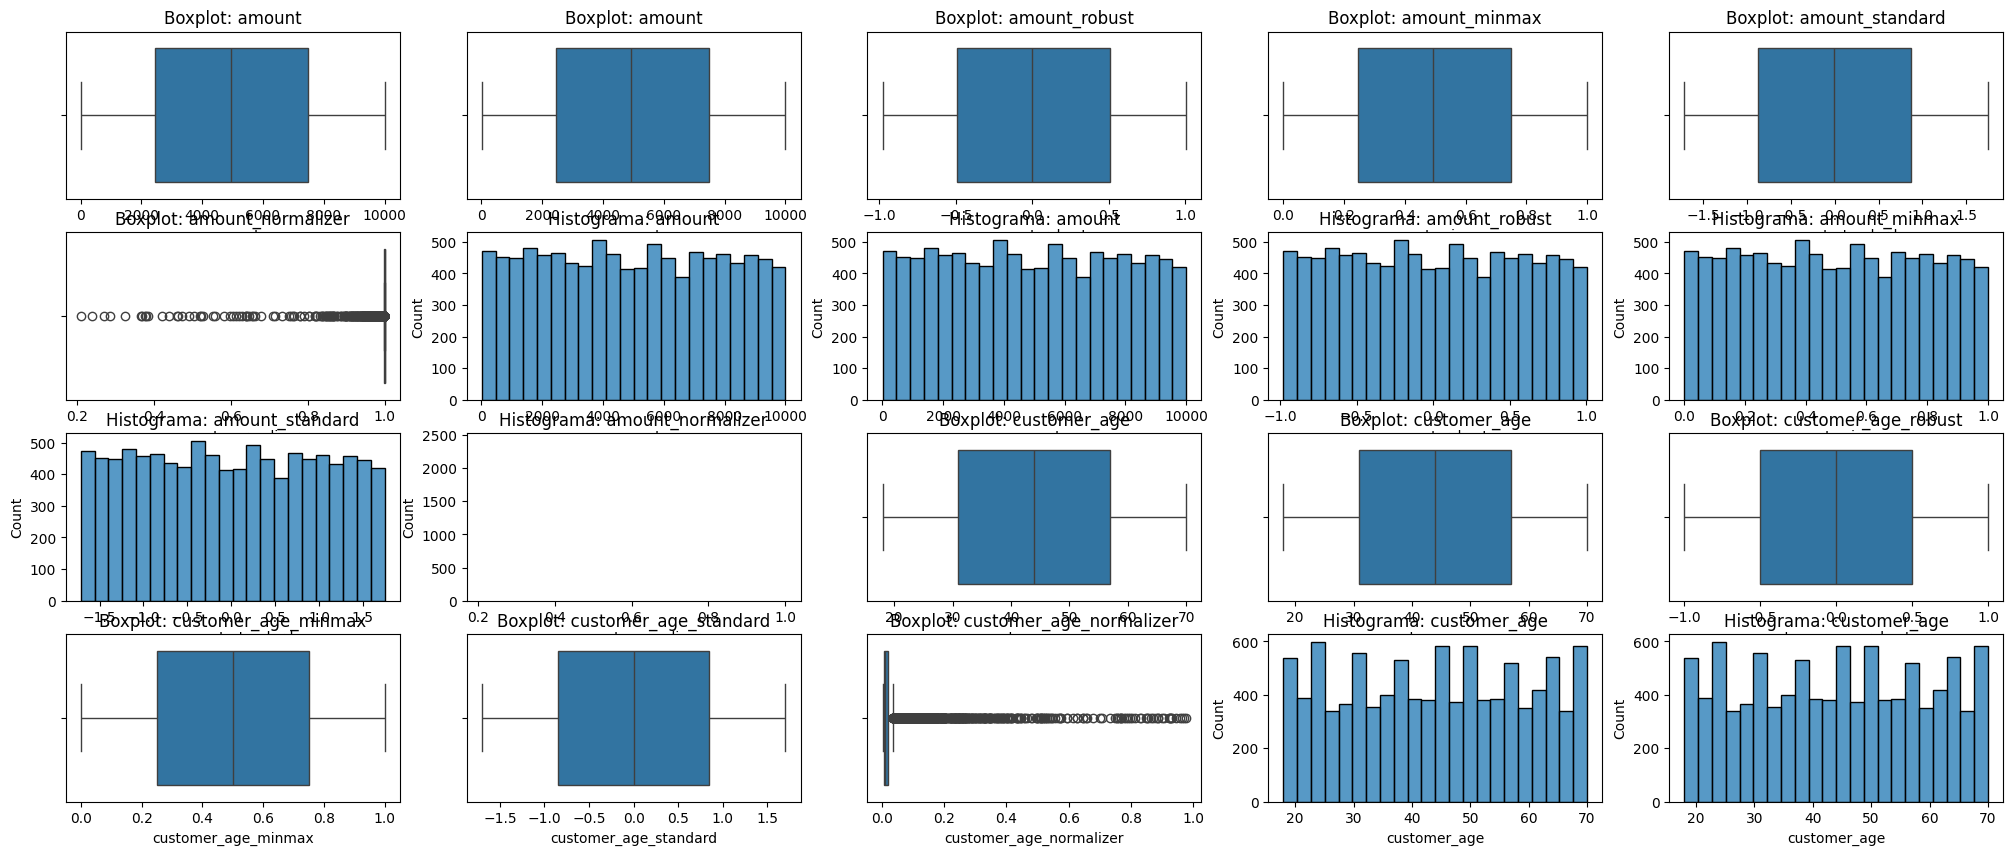

In [94]:
ss.graficar_escaladores(df_escaladores_graf, ["amount", "customer_age"], ['customer_id', 'merchant_id', 'amount', 'card_type',
       'location', 'purchase_category', 'customer_age', 'amount_robust',
       'customer_age_robust', 'amount_minmax', 'customer_age_minmax',
       'amount_standard', 'customer_age_standard', 'amount_normalizer',
       'customer_age_normalizer'])

In [96]:
df_min_max_scaler, escalador = ss.aplicar_escaladores(ta_enc, ['amount', 'customer_age'], [MinMaxScaler()], return_scaler=True)
df_min_max_scaler.head()

,customer_id,merchant_id,amount,is_fraudulent,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,amount_minmax,customer_age_minmax
0,0.540541,0.517857,5758.59,0,0.497382,0.524610,43,0.0,0.0,1.0,0.0,0.575423,0.480769
1,0.543689,0.536842,1901.56,1,0.529126,0.486978,61,0.0,0.0,0.0,1.0,0.189301,0.826923
2,0.586207,0.506024,1248.86,1,0.600000,0.524610,57,0.0,0.0,1.0,0.0,0.123960,0.750000
3,0.543689,0.525773,7619.05,1,0.600000,0.505313,59,0.0,1.0,0.0,0.0,0.761671,0.788462
4,0.470000,0.523810,1890.10,1,0.497382,0.513546,36,0.0,0.0,1.0,0.0,0.188153,0.346154


In [97]:
df_min_max_scaler.drop(columns= ['amount', 'customer_age'], inplace= True)

In [98]:
df_min_max_scaler.shape

(9884, 11)